In [1]:
# Data annotations described here:
# https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/software-and-datasets/mpii-human-pose-dataset/download
import scipy.io

mat_file_path = 'content/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat'
release_data = scipy.io.loadmat(mat_file_path)['RELEASE']
print(f"Fields inside 'RELEASE' structured array: {release_data.dtype.names}")
annolist = release_data['annolist'][0, 0]
print(f"Shape of 'annolist': {annolist.shape}")

first_image_annots = annolist[0, 0]  # Or maybe annolist[0] depending on shape
print("\nInspecti----", first_image_annots.dtype.names)
print(first_image_annots['image'][0][0][0][0])

act = release_data['act'][0, 0]
print(f"act ::: {act}")
filenames_map = {}

for datum in range(annolist.shape[1]):  # Iterate through the second dimension of annolist
    image_annot = annolist[0, datum]  # Access the element using index i in the second dimension
    filename = image_annot['image'][0][0][0][0]  # Extract the filename

    filenames_map[datum] = filename

    if datum < 5:
        print(f"Filename for index {datum}: {filename}")

Fields inside 'RELEASE' structured array: ('annolist', 'img_train', 'version', 'single_person', 'act', 'video_list')
Shape of 'annolist': (1, 24987)

Inspecti---- ('image', 'annorect', 'frame_sec', 'vididx')
037454012.jpg
act ::: [[(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 ...
 [(array(['transportation'], dtype='<U14'), array(['pushing car'], dtype='<U11'), array([[972]], dtype=uint16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]
 [(array([], dtype='<U1'), array([], dtype='<U1'), array([[-1]], dtype=int16))]]
Filename for index 0: 037454012.jpg
Filename for index 1: 095071431.jpg
Filename for index 2: 073199394.jpg
Filename for index 3: 059865848.jpg
Filename for index 4: 015601864.jpg


In [2]:
import os

act = release_data['act'][0, 0]
dataset = []
number_skipped = 0
activities_set = set()

for datum, item in enumerate(act):
    try:
        cat_name = item[0][0][0] if len(item[0]) > 0 and len(item[0][0]) > 0 else None
        act_name = item[0][1][0] if len(item[0]) > 1 and len(item[0][1]) > 0 else None
        activities = str(act_name).split(", ")
        #act_id = item[0][2][0][0] if len(item[0]) > 2 and len(item[0][2]) > 0 else None
        if not act_name:
            number_skipped += 1
            continue
    except IndexError:
        print("IndexError encountered. Skipping this item.")
        continue

    filename = "content/images/" + str(filenames_map[datum])
    if os.path.exists(filename):
        dataset.append((filename, activities))
        activities_set.update(activities)
    else:
        print(f"File {filename} does not exist. Skipping this item.")
        number_skipped += 1

print(f"number skipped: {number_skipped}")

# Žiūrim ką turim. 🥸
for i, datum in enumerate(dataset):
    filename, act_name = datum
    if i > 100:
        break
    print(f"I: {i}. Filename {filename} act Name: {act_name}")

File content/images/040348287.jpg does not exist. Skipping this item.
File content/images/013401523.jpg does not exist. Skipping this item.
File content/images/002878268.jpg does not exist. Skipping this item.
number skipped: 6957
I: 0. Filename content/images/015601864.jpg act Name: ['curling']
I: 1. Filename content/images/015599452.jpg act Name: ['curling']
I: 2. Filename content/images/005808361.jpg act Name: ['curling']
I: 3. Filename content/images/086617615.jpg act Name: ['curling']
I: 4. Filename content/images/060111501.jpg act Name: ['curling']
I: 5. Filename content/images/070807258.jpg act Name: ['curling']
I: 6. Filename content/images/002058449.jpg act Name: ['curling']
I: 7. Filename content/images/021233911.jpg act Name: ['sitting quietly']
I: 8. Filename content/images/018182497.jpg act Name: ['sitting quietly']
I: 9. Filename content/images/018340451.jpg act Name: ['sitting', 'talking in person', 'on the phone', 'computer', 'or text messaging', 'light effort']
I: 10. 

In [3]:
activities_set

{' carving wood',
 '(e.g.',
 '2.5 to 3.1 mph',
 '295)',
 '4-square',
 '75 lbs or more',
 'Alaska Native Games',
 'Anishinaabe Jingle Dancing',
 'BMX',
 'Beguine',
 'Bellair',
 'Bongo',
 "Brukin's",
 'Caribbean Quadrills',
 'Caribbean dance (Abakua',
 'Dinki Mini',
 'Elliptical trainer',
 'Eskimo Olympics',
 'Fitball exercise',
 'G',
 'Gere',
 'Greek',
 'Irish step dancing',
 'Middle Eastern',
 'Nadisodhana',
 'Navy Seal',
 'Power',
 'TV conditioning programs',
 'accordion',
 'active workstation',
 'adults playing (e.g.',
 'aerobic',
 'airline flight attendant',
 'all-terrain vehicle',
 'andor with talking involved (e.g.',
 'applying fertilizer or seeding a lawn',
 'archery',
 'arts and crafts',
 'assisting with birthing,',
 'automobile repair',
 'backpacking',
 'backstage employee',
 'backstroke',
 'badminton',
 'bakery',
 'ballet',
 'ballroom',
 'bamba y plena',
 'base jumping',
 'basketball',
 'batting',
 'beach',
 'benbe)',
 'biathlon',
 'bicycling',
 'billiards',
 'bird watching',


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from sklearn.preprocessing import LabelEncoder

# Create a label encoder for activities
label_encoder = LabelEncoder()
all_activities = list(activities_set)
label_encoder.fit(all_activities)


# Update the MPIIDataset class
class MPIIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, act_name = self.data[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB format

        if self.transform:
            image = self.transform(image)

        # Convert activity name(s) to numerical label(s)
        label = label_encoder.transform(act_name)  # Convert to numerical indices
        label = label[0] if len(label) > 0 else 0  # Handle single-label case

        return image, label


# Split the dataset into train, validation, and test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(len(dataset) * train_ratio)
val_size = int(len(dataset) * val_ratio)
test_size = len(dataset) - train_size - val_size

train_dataset = []
val_dataset = []
test_dataset = []

train_size = int(len(dataset) * train_ratio)
val_size = int(len(dataset) * val_ratio)

for i in range(len(dataset)):
    if i < train_size:
        train_dataset.append(dataset[i])
    elif i < train_size + val_size:
        val_dataset.append(dataset[i])
    else:
        test_dataset.append(dataset[i])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

transform = transforms.Compose([
    transforms.Resize(256),  # Resize the images
    transforms.CenterCrop(224),  # Crop the images
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the images
])

train_dataset = MPIIDataset(train_dataset, transform=transform)
val_dataset = MPIIDataset(val_dataset, transform=transform)
test_dataset = MPIIDataset(test_dataset, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train dataset size: 14424
Validation dataset size: 1803
Test dataset size: 1803


In [5]:
import torch

# Because not 42 🤮
random_state = 137  # 🥰

NUM_EPOCHS = 55

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 256),  # Adjust input size based on image dimensions after conv layers.
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
def train_model(train_loader, val_loader, test_loader, model_class=SimpleCNN, epochs=NUM_EPOCHS):
    import torch.optim as optim
    from tqdm import tqdm
    import matplotlib.pyplot as plt

    # Assuming you have num_classes
    num_classes = len(activities_set)

    # Initialize the model, loss function, and optimizer
    model = model_class(num_classes=len(activities_set))
    model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        print("training... 💪")
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):  # Use tqdm for progress bar
            images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=1)  # Get the predicted class indices
            train_correct += (predicted == labels).sum().item()  # Compare with labels
            train_total += labels.size(0)  # Track the total number of samples

            if batch_idx % 50 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate and append training accuracy for this epoch
        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)

        print("evaluating... ")
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
          for data, target in val_loader:
              # Move data to the selected device
              data, target = data.to(DEVICE), target.to(DEVICE)
              outputs = model(data)
              loss = criterion(outputs, target)
              val_loss += loss.item()

              predicted = torch.argmax(outputs, dim=1)
              total += target.size(0)
              correct += (predicted == target).sum().item()

        val_loss /= len(val_loader)  # Average validation loss
        val_accuracy = 100 * correct / total

        train_losses.append(loss.item()) #for plotting
        val_losses.append(val_loss) #for plotting
        #train_accuracies.append((100 * correct) / total) #for plotting
        val_accuracies.append(val_accuracy) #for plotting

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights =  model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Plot the loss and accuracy curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    return best_val_acc

training... 💪
Epoch [1/3], Batch [1/451], Loss: 6.4412
Epoch [1/3], Batch [51/451], Loss: 6.4013
Epoch [1/3], Batch [101/451], Loss: 6.2307
Epoch [1/3], Batch [151/451], Loss: 5.9548
Epoch [1/3], Batch [201/451], Loss: 5.6291
Epoch [1/3], Batch [251/451], Loss: 5.3471
Epoch [1/3], Batch [301/451], Loss: 5.2650
Epoch [1/3], Batch [351/451], Loss: 5.1366
Epoch [1/3], Batch [401/451], Loss: 5.1837
Epoch [1/3], Batch [451/451], Loss: 5.2603
evaluating...
Saving best model...💾
Epoch 1/3, Loss: 5.892850253111507
Epoch [1/3], Validation Loss: 6.8047, Validation Accuracy: 1.33%
training... 💪
Epoch [2/3], Batch [1/451], Loss: 5.2466
Epoch [2/3], Batch [51/451], Loss: 5.1806
Epoch [2/3], Batch [101/451], Loss: 5.3287
Epoch [2/3], Batch [151/451], Loss: 5.1603
Epoch [2/3], Batch [201/451], Loss: 5.2038
Epoch [2/3], Batch [251/451], Loss: 5.1513
Epoch [2/3], Batch [301/451], Loss: 5.2414
Epoch [2/3], Batch [351/451], Loss: 5.1204
Epoch [2/3], Batch [401/451], Loss: 5.1767
Epoch [2/3], Batch [451/4

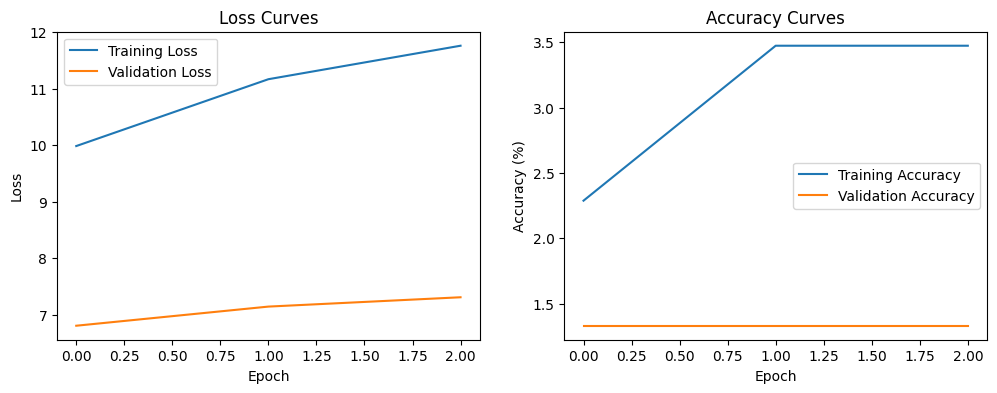

1.3311148086522462

In [9]:
import torch
torch.cuda.empty_cache()
train_model(train_loader, val_loader, test_loader, model_class=SimpleCNN, epochs=3)

In [8]:
#mimic Big Transfer (BiT)

import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += shortcut
        x = self.relu(x)
        return x

class BiTLikeModel(nn.Module):
    def __init__(self, num_classes):
        super(BiTLikeModel, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Stacking residual blocks
        self.layer1 = self._make_layer(64, 64, num_blocks=3, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=4, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=6, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=3, stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
import torch
torch.cuda.empty_cache()
train_model(train_loader, val_loader, test_loader, model_class=BiTLikeModel, epochs=50)

training... 💪
Epoch [1/50], Batch [1/451], Loss: 6.6995
Epoch [1/50], Batch [51/451], Loss: 5.1619
Epoch [1/50], Batch [101/451], Loss: 5.1105
Epoch [1/50], Batch [151/451], Loss: 4.7515
Epoch [1/50], Batch [201/451], Loss: 5.3574
Epoch [1/50], Batch [251/451], Loss: 4.8927
Epoch [1/50], Batch [301/451], Loss: 5.0020
Epoch [1/50], Batch [351/451], Loss: 5.1215
Epoch [1/50], Batch [401/451], Loss: 4.9601
Epoch [1/50], Batch [451/451], Loss: 5.0299
evaluating... 
Saving best model...💾
Epoch 1/50, Loss: 5.090260747795359
Epoch [1/50], Validation Loss: 7.7234, Validation Accuracy: 5.88%
training... 💪
Epoch [2/50], Batch [1/451], Loss: 4.5553
Epoch [2/50], Batch [51/451], Loss: 4.9986
Epoch [2/50], Batch [101/451], Loss: 4.7765
Epoch [2/50], Batch [151/451], Loss: 4.5020
Epoch [2/50], Batch [201/451], Loss: 4.6635
